<a href="https://colab.research.google.com/github/Deepkhut/SRIP_IITGN_2022_ML/blob/main/TASK3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##### download MNIST data and store it in under directory _DATA

import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np

# path to data directory
_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
    """Download a url to a file in the JAX data temp directory."""
    if not path.exists(_DATA):
        os.makedirs(_DATA)
    out_file = path.join(_DATA, filename)
    if not path.isfile(out_file):
        urllib.request.urlretrieve(url, out_file)
        print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
    """Flatten all but the first dimension of an ndarray."""
    return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
    """Download and parse the raw MNIST dataset."""
    # CVDF mirror of http://yann.lecun.com/exdb/mnist/
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

    def parse_labels(filename):
        with gzip.open(filename, "rb") as fh:
            _ = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, "rb") as fh:
            _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()),
                          dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
        _download(base_url + filename, filename)

    train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
    train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
    test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
    test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

    return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
    """Download, parse and process MNIST data to unit scale and one-hot labels."""
    train_images, train_labels, test_images, test_labels = mnist_raw()

    train_images = _partial_flatten(train_images) / np.float32(255.)
    test_images = _partial_flatten(test_images) / np.float32(255.)
    train_labels = _one_hot(train_labels, 10)
    test_labels = _one_hot(test_labels, 10)

    if permute_train:
        perm = np.random.RandomState(0).permutation(train_images.shape[0])
        train_images = train_images[perm]
        train_labels = train_labels[perm]

    return train_images, train_labels, test_images, test_labels

In [ ]:
def my_generator():
    #while True:
        for j in range(10):
            yield j
            
gen = my_generator()
print(gen) # shows a generator object

print('\nfirst loop:\n')   

# call generator
for i in range(4):
    print(i, next(gen) )
    
print('\nsecond loop:\n')    
    
for i in range(10):
    print(i, next(gen) )

<generator object my_generator at 0x7f9e5d538a50>

first loop:

0 0
1 1
2 2
3 3

second loop:

0 4
1 5
2 6
3 7
4 8
5 9


StopIteration: ignored

In [ ]:
### define minibatches

# fix seed
seed=0
np.random.seed(seed)

##### define data variables and the minibatch generator
# load MNIST data
train_images, train_labels, test_images, test_labels = mnist()

print('\ntrain data: image shape: {}, label shape: {}.'.format(train_images.shape, train_labels.shape ))
print('test data : image shape: {}, label shape: {}.\n'.format(test_images.shape, test_labels.shape ))


# size of a single minibatch
batch_size=128 
# size of the trining set
num_train = train_images.shape[0] 
# define number of complete minibatches (data size need not be muptiple of batch_size)
num_complete_batches, leftover = divmod(num_train, batch_size)
# total number of minibatches is the smallest integer to fit all minibatches in the dataset
num_batches = num_complete_batches + bool(leftover)


def data_stream():
    """
    This function defines a generator which produces random batches of data, one at a time.
    
    """
    rng = np.random.RandomState(0)
    while True:
        perm = rng.permutation(num_train) # compute a random permutation
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield train_images[batch_idx], train_labels[batch_idx]

# define the batches generator
batches = data_stream()


train data: image shape: (60000, 784), label shape: (60000, 10).
test data : image shape: (10000, 784), label shape: (10000, 10).



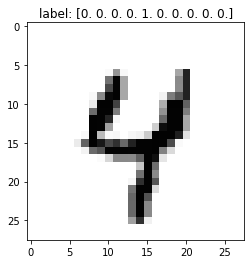

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
# static plots
%matplotlib inline 

### show the first data point as an example
n=1111 # test data point number

plt.imshow(test_images[n].reshape(28,28),cmap='Greys')
plt.title('label: {}'.format(test_labels[n]) )

plt.show()

Define CNN model

In [ ]:
import jax.numpy as jnp   # jax's numpy version with GPU support
from jax import random    # used to define a RNG key to control the random input in JAX
from jax.experimental import stax # neural network library
from jax.experimental.stax import Dense, Relu, LogSoftmax # neural network layers
from jax.experimental.stax import GeneralConv, Flatten # neural network layers

rng = random.PRNGKey(seed)
# cast data into 2D image format
train_images = train_images.reshape(-1,1,28,28) # -1: number of data points, 1: input channels, (28,28) = (height, width) dimensions of image
test_images = test_images.reshape(-1,1,28,28)

# conv net convention
dim_nums=('NCHW', 'OIHW', 'NCHW') # default for (input, filters, output)

# define functions which initialize the parameters and evaluate the model
initialize_params, predict = stax.serial(    
                                            ### convolutional NN (CNN)
                                            GeneralConv(dim_nums, 16, (4,4), strides=(4,4) ), # 16 output channels, (4,4) filter
                                            Relu,
                                            GeneralConv(dim_nums, 32, (3,3), strides=(1,1) ), # 32 output channels, (3,3) filter
                                            Relu,
                                            Flatten, # flatten output
                                            Dense(256), # 256 hidden neurons
                                            Relu,
                                            Dense(10), # 10 output neurons
                                            LogSoftmax # NB: computes the log-probability
                                        )

# initialize the model parameters
output_shape, inital_params = initialize_params(rng, (-1, 1, 28, 28)) # conv layer, 1 input channel, 28x28 pixes in each image

print('\noutput shape of the model is {}.\n'.format(output_shape))

# check how network works on 3 examples
predictions = predict(inital_params, test_images[0:3])

# print shape of output
print("actual output shape is:", predictions.shape)

# check if probability is conserved
print('log(softmax) values:', predictions[0])
print('conservation of probability', np.sum(jnp.exp(predictions), axis=1))

/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)



output shape of the model is (-1, 10).

actual output shape is: (3, 10)
log(softmax) values: [-2.264744  -2.4081535 -2.2366064 -2.302778  -2.4543524 -2.3551545
 -2.2510574 -2.1797054 -2.268157  -2.3361628]
conservation of probability [1.0000001 1.0000001 1.0000001]


Define Loss/cost function

In [ ]:
### define loss and accuracy functions

from jax import grad
from jax.tree_util import tree_flatten # jax params are stored as nested tuples; useing this to manipulate tuples


def l2_regularizer(params, lmbda):
    """
    Define l2 regularizer: $\lambda \ sum_j ||theta_j||^2 $ for every parameter in the model $\theta_j$
    
    """
    return lmbda*jnp.sum(jnp.array([jnp.sum(jnp.abs(theta)**2) for theta in tree_flatten(params)[0] ]))


def loss(params, batch):
    """
    Define cost (or lost) function for softmax classification. 
    
    """
    inputs, targets = batch
    preds = predict(params, inputs)
    return -jnp.mean(jnp.sum(preds * targets, axis=1)) + l2_regularizer(params, 0.001)


def mean_accuracy(params, batch):
    """
    Define accuracy function: the mean number of datapoints which have correct preductions. 
    This function is not used for training; only to test the performance. 
    
    """
    inputs, targets = batch
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

Define the optimizer

In [ ]:
### define generalized gradient descent optimizer and a function to update model parameters

from jax.experimental import optimizers # gradient descent optimizers
from jax import jit

step_size = 0.001 # step size or learning rate 
momentum_mass = 0.9 # "gamma" parameter in GD+momentum

# compute optimizer functions
opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)


# define function which updates the parameters using the change computed by the optimizer
@jit # Just In Time compilation speeds up the code; requires to use jnp everywhere; remove when debugging
def update(i, opt_state, batch):
    """
    i: int,
        counter to count how many update steps we have performed
    opt_state: object,
        the state of the optimizer
    batch: np.array
        batch containing the data used to update the model
        
    Returns: 
    opt_state: object,
        the new state of the optimizer
        
    """
    # get current parameters of the model
    current_params = get_params(opt_state)
    # compute gradients
    grad_params = grad(loss)(current_params, batch)
    # use the optimizer to perform the update using opt_update
    return opt_update(i, grad_params, opt_state)

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


Train Model

In [ ]:
import time
import itertools

# define geenrator to count the number of updates
itercount = itertools.count()

# define number of training epochs
num_epochs = 101

# define figures of merit
train_accuracy=np.zeros(num_epochs)
test_accuracy=np.zeros_like(train_accuracy)

print("\nStarting training...\n")

# set the initial model parameters in the optimizer
opt_state = opt_init(inital_params)

# loop over the number of training epochs
for epoch in range(num_epochs): 
    
    ### record time
    start_time = time.time()
    
    ### train in minibatches until the entire dataset is exhausted: 
    # the entire dataset is divided into _random_ minibatches; 
    # all minibatches are shown to the model before going to next epoch
    for _ in range(num_batches):
        # use the data to update the model parameters
        opt_state = update(next(itercount), opt_state, next(batches))
        
    ### record time needed for a single epoch
    epoch_time = time.time() - start_time
    
    ### evaluate performance of the model at each fixed epoch
    
    # retrieve current model parameters
    params = get_params(opt_state)
    
    # measure the accuracy on the training and test datasets
    train_accuracy[epoch] = mean_accuracy(params, (train_images, train_labels))
    test_accuracy[epoch] = mean_accuracy(params, (test_images, test_labels))
    
    # print results every 10 epochs
    if epoch % 10 == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(train_accuracy[epoch]))
        print("Test set accuracy {}\n".format(test_accuracy[epoch]))


Starting training...

Epoch 0 in 9.64 sec
Training set accuracy 0.8501333594322205
Test set accuracy 0.8628999590873718

Epoch 10 in 9.73 sec
Training set accuracy 0.9580000042915344
Test set accuracy 0.9599999785423279

Epoch 20 in 7.85 sec
Training set accuracy 0.972516655921936
Test set accuracy 0.9708999991416931

Epoch 30 in 7.97 sec
Training set accuracy 0.9777833223342896
Test set accuracy 0.9739999771118164

Epoch 40 in 7.88 sec
Training set accuracy 0.9822500348091125
Test set accuracy 0.9771999716758728

Epoch 50 in 7.92 sec
Training set accuracy 0.9850333333015442
Test set accuracy 0.9800999760627747

Epoch 60 in 7.87 sec
Training set accuracy 0.9858666658401489
Test set accuracy 0.9789999723434448

Epoch 70 in 7.72 sec
Training set accuracy 0.9880833625793457
Test set accuracy 0.9803999662399292

Epoch 80 in 8.09 sec
Training set accuracy 0.9890833497047424
Test set accuracy 0.9818999767303467

Epoch 90 in 8.02 sec
Training set accuracy 0.989549994468689
Test set accuracy 